In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Read Data

In [3]:
df = pd.read_csv('/content/drive/My Drive/Data Science/Capstone Project/Loss_Ratio_Modelling.csv')
df.shape

(9134, 29)

#### Split Train and Test Data

In [0]:
target_col = 'Loss_Ratio_Classified'
feature_cols = ['Vehicle Size','Gender','Income','Location Code',
                'Months Since Last Claim','Vehicle Class']

scaler = MinMaxScaler()

df[feature_cols] = scaler.fit_transform(df[feature_cols])

X =  df[feature_cols]
y = df[target_col]

# OverSample to negate Class Imbalance
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=1)


#### Create a Model Pipeline

In [0]:
def model_evaluation(model_type):
    model = model_type
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pp = model.predict_proba(X_test)
    print(confusion_matrix(y_test, y_pred))
    print('Accuracy =',metrics.accuracy_score(y_test, y_pred))
    print('Precision =',metrics.precision_score(y_test, y_pred))
    print('Recall =',metrics.recall_score(y_test, y_pred))
    print('F1 =',metrics.f1_score(y_test, y_pred))

#### Logistic Regression

In [10]:
model_evaluation(model_type=LogisticRegression(solver='lbfgs', class_weight='auto'))

[[ 924  967]
 [ 825 1032]]
Accuracy = 0.5218783351120597
Precision = 0.5162581290645323
Recall = 0.555735056542811
F1 = 0.5352697095435685


#### Random Forest

In [21]:
model_evaluation(model_type=RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0))

[[ 697 1194]
 [ 562 1295]]
Accuracy = 0.5314834578441836
Precision = 0.5202892728003214
Recall = 0.6973613354873451
F1 = 0.5959502991256328


#### SVM

In [18]:
model_evaluation(model_type=svm.SVC(gamma='scale', probability=True, random_state=0))

[[ 956  935]
 [ 708 1149]]
Accuracy = 0.561632870864461
Precision = 0.5513435700575816
Recall = 0.6187399030694669
F1 = 0.5831007358538443


#### Naive Bayes

In [12]:
model_evaluation(model_type=GaussianNB())

[[ 814 1077]
 [ 766 1091]]
Accuracy = 0.5082710779082177
Precision = 0.5032287822878229
Recall = 0.5875067312870221
F1 = 0.5421118012422361


#### AdaBoost

In [13]:
model_evaluation(AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                    learning_rate=1.0, n_estimators=10, random_state=0))

[[ 715 1176]
 [ 555 1302]]
Accuracy = 0.5381536819637139
Precision = 0.5254237288135594
Recall = 0.7011308562197092
F1 = 0.6006920415224912


#### XGBoost

In [20]:
model_evaluation(model_type=XGBClassifier(max_depth=20, learning_rate=1, n_estimators=10, random_state=0))

[[1444  447]
 [ 124 1733]]
Accuracy = 0.8476520811099253
Precision = 0.794954128440367
Recall = 0.93322563274098
F1 = 0.8585583353975724


#### ROC Curve for XGBoost, SVM, AdaBoost

In [22]:
xgb_model = XGBClassifier(max_depth=20, learning_rate=1, n_estimators=10, random_state=0)
xgb_model.fit(X_train, y_train)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rf_model.fit(X_train, y_train)
ada_model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0, n_estimators=10, random_state=0)
ada_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=10, random_state=0)

In [0]:
x=xgb_model.predict_proba(X_test)
y=rf_model.predict_proba(X_test)
z=ada_model.predict_proba(X_test)

In [24]:
Y_pp = pd.DataFrame(x,columns=['xgb_class_0_pp','xgb_class_1_pp'])
Y_pp_1 = pd.DataFrame(y,columns=['rf_class_0_pp','rf_class_1_pp'])
Y_pp_2 = pd.DataFrame(z,columns=['ada_class_0_pp','ada_class_1_pp'])
Y_pp = Y_pp.join(Y_pp_1)
Y_pp = Y_pp.join(Y_pp_2)
Y_pp.head()

,xgb_class_0_pp,xgb_class_1_pp,rf_class_0_pp,rf_class_1_pp,ada_class_0_pp,ada_class_1_pp
0,0.039598,0.960402,0.466864,0.533136,0.487155,0.512845
1,0.887074,0.112926,0.520033,0.479967,0.503740,0.496260
2,0.126029,0.873971,0.483679,0.516321,0.498391,0.501609
3,0.522997,0.477003,0.494341,0.505659,0.498391,0.501609
4,0.116929,0.883071,0.522944,0.477056,0.507833,0.492167


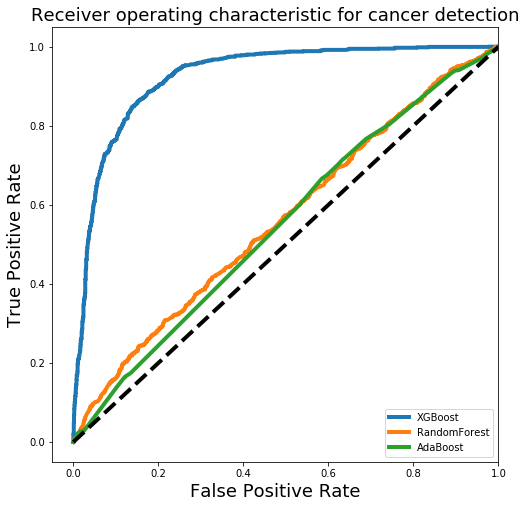

In [25]:
# Find fpr, tpr
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, Y_pp['xgb_class_1_pp'])
fpr_rf, tpr_rf, _ = roc_curve(y_test, Y_pp['rf_class_1_pp'])
fpr_ada, tpr_ada, _ = roc_curve(y_test, Y_pp['ada_class_1_pp'])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_ada = auc(fpr_ada, tpr_ada)
# Find auc

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])

# Plot fpr, tpr
plt.plot(fpr_xgb, tpr_xgb, label='ROC curve (area = %0.2f)' % roc_auc_xgb, linewidth=4)
plt.plot(fpr_rf, tpr_rf, label='ROC curve (area = %0.2f)' % roc_auc_rf, linewidth=4)
plt.plot(fpr_ada, tpr_ada, label='ROC curve (area = %0.2f)' % roc_auc_ada, linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(['XGBoost', 'RandomForest', 'AdaBoost'], loc="lower right")
plt.show()